# Imputación de datos faltantes

**Librerías**:

In [3]:
!pip install pyjanitor==0.22.0

In [4]:
import janitor
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno
import nhanes.load

## Preparando datos: _National Health and Nutrition Examination Survey_

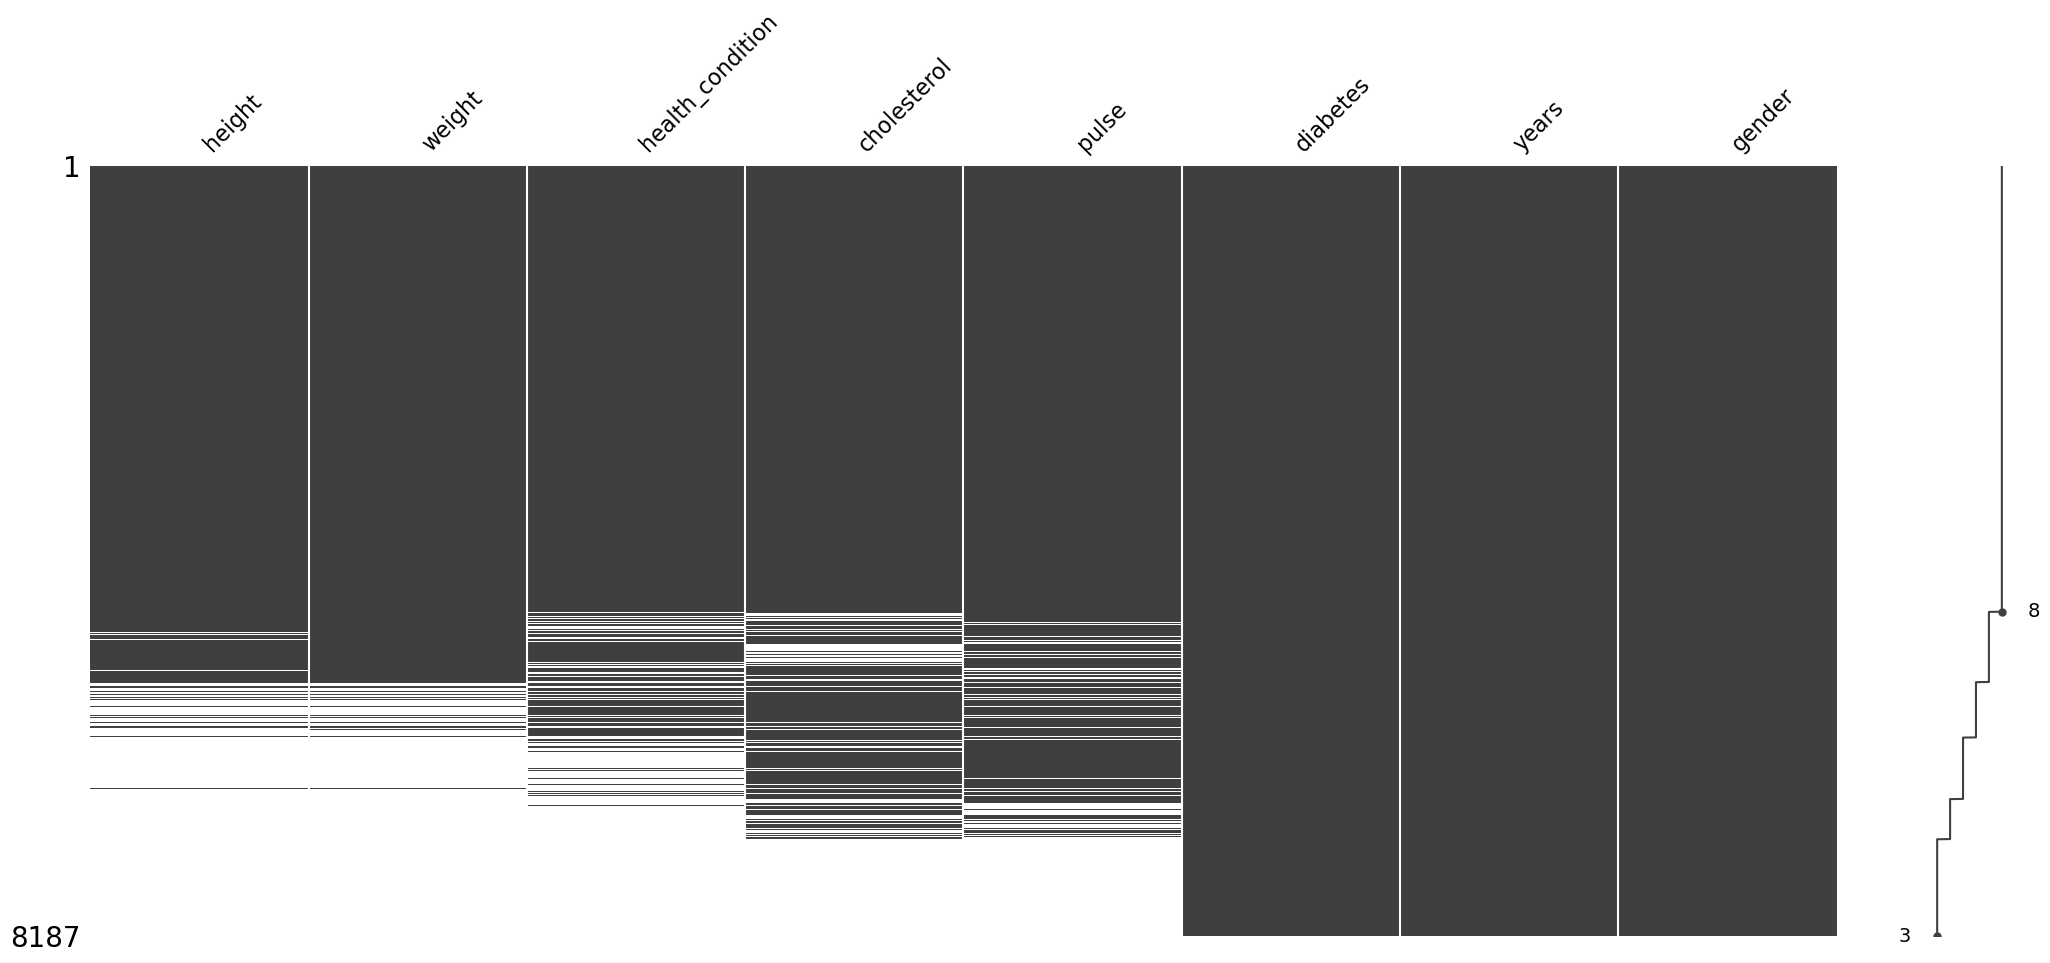

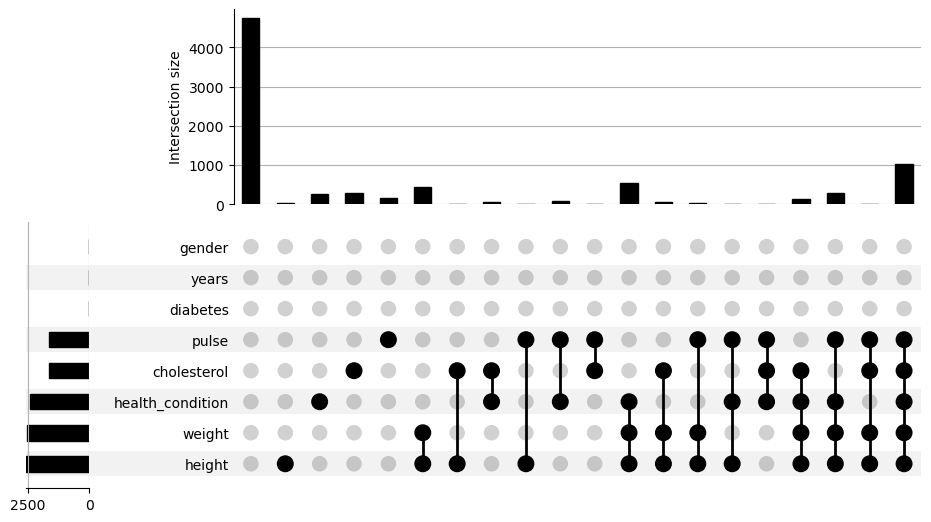

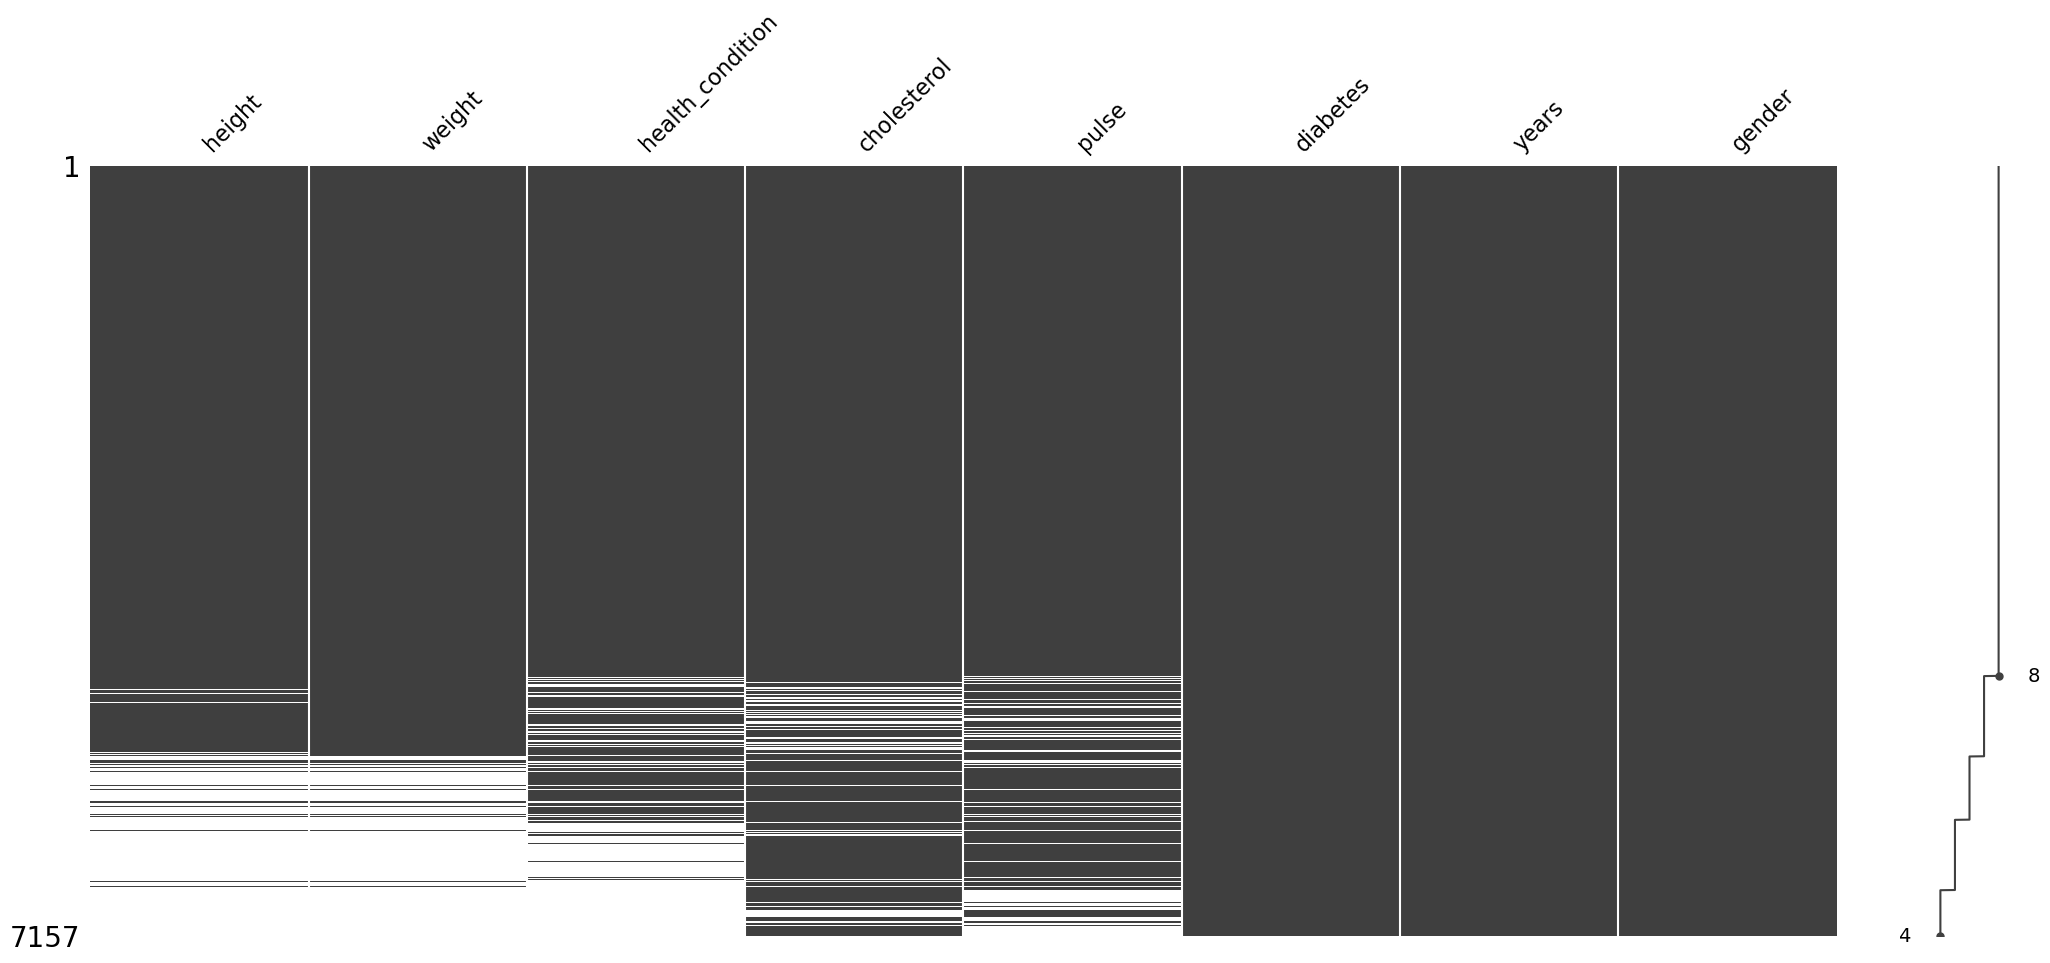

In [5]:
%run 2.1-Imputation_missing_values-data_loaded.ipynb